### This notebook is used for developing charCNN model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, GlobalMaxPool1D, BatchNormalization
from keras.layers import LSTM, Lambda, concatenate
import keras.backend as K
import tensorflow as tf
import keras.callbacks

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

Using TensorFlow backend.


## Data Processing

In [2]:
# load data
empathies = pd.read_csv('./empathies.csv')
msg = pd.read_csv('./msg_fasttext.csv')
msg.shape

(3561, 6)

In [3]:
# drop irrelevant columns
msg = msg.drop(msg.columns[0:2], axis=1)

In [4]:
# get a set of all the characters in the data
char_set = set()
for ms in msg['message']:
    for ch in ms:
        char_set.add(ch)

In [5]:
# get a map of character and its corresponding index
char_indices = dict((c, i) for i, c in enumerate(char_set))
indices_char = dict((i, c) for i, c in enumerate(char_set))

In [6]:
# one-hot encoding of labels
sentiments = np.zeros((msg.shape[0], empathies.shape[0]), dtype = np.int64)
i = 0
for emps in msg['empathy']:
    for emp in emps.split(','):
        emp = emp.strip()
        try:
            idx = empathies[empathies['empathy'] == emp].index[0]
            sentiments[i][idx] = 1
        except:
            print(emp)
    i += 1

In [7]:
# number of unique characters
len(char_indices)

101

In [8]:
y = sentiments.copy()

In [9]:
# transform original data into character index format
max_len = 100
X = np.zeros((msg.shape[0], max_len), dtype=np.int64)

for i, sen in enumerate(msg['message']):
    for j, ch in enumerate(sen):
        if j < max_len:
            X[i, max_len-1-j] = char_indices[ch]

In [10]:
# split into training and validation data
X_train = X[:2500]
X_test = X[2500:]

y_train = y[:2500]
y_test = y[2500:]

# dimension of character embedding
char_embedding = 100

## Model Setup & Training

In [11]:
# used for embedding layer
def binarize(x, sz=100):
    '''
    sz: embedding size
    '''
    import tensorflow as tf
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))


def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 100

In [12]:
def char_block(in_layer, nb_filter=(64, 100), filter_length=(3, 3), subsample=(2, 1), pool_length=(2, 2)):
    block = in_layer
    for i in range(len(nb_filter)):

        block = Conv1D(filters=nb_filter[i],
                       kernel_size=filter_length[i],
                       padding='valid',
                       activation='tanh',
                       strides=subsample[i])(block)

#         block = BatchNormalization()(block)
#         block = Dropout(0.2)(block)
        if pool_length[i]:
            block = MaxPooling1D(pool_size=pool_length[i])(block)

    # block = Lambda(max_1d, output_shape=(nb_filter[-1],))(block)
    block = GlobalMaxPool1D()(block)
    block = Dense(128, activation='relu')(block)
    return block

In [13]:
max_features = len(char_set) + 1

In [14]:
in_sentence = Input(shape=(max_len,), dtype='int64')

In [15]:
embedded = Lambda(binarize, output_shape=binarize_outshape)(in_sentence)

In [16]:
block2 = char_block(embedded, (128, 256), filter_length=(5, 5), subsample=(1, 1), pool_length=(2, 2))
block3 = char_block(embedded, (192, 320), filter_length=(7, 5), subsample=(1, 1), pool_length=(2, 2))

sent_encode = concatenate([block2, block3], axis=-1)

In [17]:
output = Dense(64, activation='softmax')(sent_encode)

In [18]:
model = Model(inputs=in_sentence, outputs=output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 100, 100)      0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 96, 128)       64128       lambda_1[0][0]                   
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 94, 192)       134592      lambda_1[0][0]                   
___________________________________________________________________________________________

In [19]:
earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

optimizer = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
# training
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=256, epochs=30, 
          shuffle=True, callbacks=[earlystop_cb])

Train on 2500 samples, validate on 1061 samples
Epoch 1/30
2500/2500 [==============================] - 19s - loss: 5.2398 - acc: 0.0544 - val_loss: 5.0655 - val_acc: 0.0980
Epoch 2/30
2500/2500 [==============================] - 20s - loss: 4.8687 - acc: 0.1176 - val_loss: 4.8383 - val_acc: 0.1527
Epoch 3/30
2500/2500 [==============================] - 20s - loss: 4.6107 - acc: 0.1752 - val_loss: 4.5981 - val_acc: 0.1932
Epoch 4/30
2500/2500 [==============================] - 22s - loss: 4.3243 - acc: 0.2384 - val_loss: 4.3504 - val_acc: 0.2762
Epoch 5/30
2500/2500 [==============================] - 22s - loss: 4.0350 - acc: 0.3188 - val_loss: 4.1267 - val_acc: 0.3186
Epoch 6/30
2500/2500 [==============================] - 24s - loss: 3.7449 - acc: 0.3592 - val_loss: 3.9239 - val_acc: 0.3516
Epoch 7/30
2500/2500 [==============================] - 26s - loss: 3.4692 - acc: 0.4224 - val_loss: 3.7656 - val_acc: 0.3657
Epoch 8/30
2500/2500 [==============================] - 25s - loss: 3.

In [21]:
# model.save('./charModel_final.h5')
# model = load_model('./charModel_final.h5')

In [30]:
# prediction
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

## Metrics (relaxed, nonrelaxed & bar-chart)

In [31]:
# get a map that contains empathy and its corresponding polarity score, this map will be used to compute metrics
dict_polarities = {}
for i in range(empathies.shape[0]):
    dict_polarities[empathies.iloc[i][0]] = float(empathies.iloc[i][1])

The following function is used to compare against the ground truth in a **relaxed**  format, which means if the predicted class is not exactly the same as the truth, but has the same polarity score. The prediction will still be counted as truth positive

The output is a dictionary contained label: number of true positives, false positives and false negatives
the output will be used for calculating overall precision, recall and F1 score

In [32]:
def compare_truth_relaxed(cutoff_value, dict_polarities, model, inputs, all_preds, start, stop):
    '''
    output: {label: [TP, FP, FN]}
    '''
    label_s = list(dict_polarities.keys())
    res = {}
    
    for l in label_s:
        # True Positives, False Positives, False Negatives
        res[l] = [0, 0, 0]
    
    j = -1
    for i in range(start, stop):
        j += 1
        preds = all_preds[j]
        true_scores = [dict_polarities[la.strip()] for la in msg.iloc[i]['empathy'].split(',') if la != '']
        
        # store predicted labels and the corresponding polarity score
        pred_labs, scores  = [], []
        preds = [list(empathies['empathy'][np.argsort(preds)[63:58:-1]]), np.sort(preds)[63:58:-1]]
        
        idx = 0
        for lab, p in zip(preds[0], preds[1]):
            idx += 1
            if p > cutoff_value or idx == 1:
                pred_labs.append(lab)
                scores.append(dict_polarities[lab])
                if lab in msg.iloc[i]['empathy'] or dict_polarities[lab] in true_scores:
                    # true positive
                    res[lab][0] += 1
                if lab not in msg.iloc[i]['empathy'] and dict_polarities[lab] not in true_scores:
                    # false positive
                    res[lab][1] += 1
                
        for true_lab in msg.iloc[i]['empathy'].split(','):
            true_lab = true_lab.strip()
            if true_lab != '' and true_lab != ' ' and true_lab not in pred_labs and dict_polarities[lab] not in scores:
                # false negative
                res[true_lab][2] += 1
                
    return res

Similiar as the above function. The following function is used to compare against the ground truth, but in a **nonrelaxed** format -- the predicted class has to be exactly the same as the truth in order to be counted as true positive.

The output is a dictionary contained label: number of true positives, false positives and false negatives
the output will be used for calculating overall precision, recall and F1 score

In [33]:
def compare_truth_nonrelaxed(cutoff_value, dict_polarities, model, inputs, all_preds, start, stop):
    '''
    output: {label: [TP, FP, FN]}
    '''
    label_s = list(dict_polarities.keys())
    res = {}
    
    for l in label_s:
        # True Positives, False Positives, False Negatives
        res[l] = [0, 0, 0]
    
    j = -1
    for i in range(start, stop):
        j += 1
        preds = all_preds[j]
        true_scores = [dict_polarities[la.strip()] for la in msg.iloc[i]['empathy'].split(',') if la != '']
        
        # store predicted labels and the corresponding polarity score
        pred_labs, scores  = [], []
        preds = [list(empathies['empathy'][np.argsort(preds)[63:58:-1]]), np.sort(preds)[63:58:-1]]
        
        for lab, p in zip(preds[0], preds[1]):
            if p > cutoff_value:
                pred_labs.append(lab)
                scores.append(dict_polarities[lab])
                print(lab)
                if lab in msg.iloc[i]['empathy']:
                    # true positive
                    res[lab][0] += 1
                if lab not in msg.iloc[i]['empathy']:
                    # false positive
                    res[lab][1] += 1
                
        for true_lab in msg.iloc[i]['empathy'].split(','):
            true_lab = true_lab.strip()
            if true_lab != '' and true_lab != ' ' and true_lab not in pred_labs:
                # false negative
                res[true_lab][2] += 1
                
    return res

In [34]:
def overall_score(res):
    '''
    output precision, recall and F1 score
    '''
    num_TP, num_FP, num_FN = 0, 0, 0
    
    for _, vals in res.items():
        num_TP += vals[0]
        num_FP += vals[1]
        num_FN += vals[2]
            
    precision = num_TP/(num_TP+num_FP)
    recall = num_TP/(num_TP+num_FN)
    
    return precision, recall, 2/(1/precision + 1/recall)

In [35]:
# explore the best cutoff value with the training data
ps, rs, fs = [], [], []
for proposed_cut in np.arange(.0, .6, .1):
    res = compare_truth_relaxed(proposed_cut, dict_polarities, model, msg, train_preds, 0, 2500)
    p, r, f = overall_score(res)
    ps.append(p)
    rs.append(rs)
    fs.append(f)

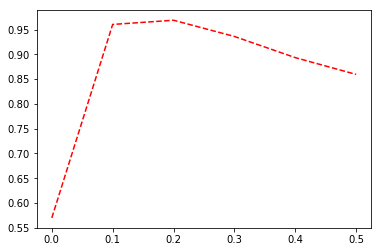

In [36]:
# plot the change of F1 score as the cutoff value increases from 0.0 to 0.6
proposed_cuts = np.arange(.0, .6, .1)
# red dashes
plt.plot(proposed_cuts, fs, 'r--')
plt.show()

In [37]:
max_fs_idx = fs.index(max(fs))
np.arange(.0, .6, .1)[max_fs_idx]

0.20000000000000001

In [38]:
def confu_plot(con_matrix):
    '''
    generate bar-chart of true positives, false positives and false negatives for each class
    '''
    names = []
    TP, FP, FN = [], [], []
    for k, vals in con_matrix.items():
        name=k.replace('__label__', '')
        names.append(name)
        TP.append(vals[0])
        FP.append(vals[1])
        FN.append(vals[2])

    trace1 = go.Bar(
        x=names,
        y=TP,
        name='True Positive'
    )

    trace2 = go.Bar(
        x=names,
        y=FP,
        name='False Positive'
    )

    trace3 = go.Bar(
        x=names,
        y=FN,
        name='False Negative'
    )

    data = [trace1, trace2, trace3]
    layout = go.Layout(
        barmode='group',

        xaxis=dict(
            title='labels',
            titlefont=dict(
                size=18,
            ),
            showticklabels=True,
            tickangle=45,
            tickfont=dict(
                size=14,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        )
    )

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='grouped-bar') 

In [39]:
res = compare_truth_relaxed(.2, dict_polarities, model, msg, test_preds, 2500, msg.shape[0])

In [40]:
overall_score(res)

(0.6674509803921569, 0.6135544340302812, 0.6393688955672427)

In [41]:
confu_plot(res)

In [42]:
# used for transform a string into the acceptable format for the model
def text_processor(input_str, char_indices, max_len = 100):
    '''
    ---
    args:
        input_str: an input string
        char_indices: map of character index calculated from above
        max_len: the length of input that the model accepts
    ---
    return:
       padded sequence for the model 
    '''
    sen2input = np.zeros((1, max_len), dtype=np.int64)
    
    for j, ch in enumerate(input_str):
        if j < max_len:
            sen2input[0, max_len-1-j] = char_indices[ch]
    
    return sen2input

In [43]:
random_input = text_processor('huuungry', char_indices)
random_pred = model.predict(random_input)
[list(empathies['empathy'][np.argsort(random_pred)[0][63:58:-1]]), np.sort(random_pred)[0][63:58:-1]]

[['hungry', 'angry', 'annoyed', 'sad', 'uneasy'],
 array([ 0.68242598,  0.26267356,  0.01349587,  0.0098852 ,  0.00448579], dtype=float32)]